<a href="https://colab.research.google.com/github/Tanainan/Covid-19Thailand/blob/main/Predicting_Apple_mobility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U tensorflow-addons
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout, Activation
from keras.layers import GRU
from keras.layers import SimpleRNN
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow_addons.layers import InstanceNormalization, GroupNormalization
from keras.layers import LayerNormalization
from keras.layers import Flatten
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import pandas as pd
import numpy as np
from statistics import stdev
from statistics import mean
from matplotlib import pyplot
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)
from matplotlib import pyplot as plt
import datetime as dt
import matplotlib.ticker as ticker
import plotly.graph_objects as go
from statsmodels.graphics.factorplots import interaction_plot
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', None)
import itertools
!pip install -U scikit-learn
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.utils import to_categorical


     |████████████████████████████████| 1.1 MB 5.2 MB/s 


/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



     |████████████████████████████████| 23.2 MB 121 kB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [52]:
data = read_csv("https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/d98db2da901d5707dc3225ee163903005e7645f3/data/OxCGRT_latest.csv")

data = pd.DataFrame(data)

# select Thailand only
data = data.loc[data['CountryName'] == "Thailand"]

# select columns
data = data[["Date", "C1_School closing",
            "C2_Workplace closing",
            "C3_Cancel public events", "C4_Restrictions on gatherings",
            "C5_Close public transport", "C6_Stay at home requirements",
            "C7_Restrictions on internal movement", "C8_International travel controls",
            "H1_Public information campaigns", "ConfirmedCases", "ConfirmedDeaths"]]

# change column names
data = data.rename(columns = {"C1_School closing":"C1_School.closing",
            "C2_Workplace closing":"C2_Workplace.closing",
            "C3_Cancel public events":"C3_Cancel.public.events",
            "C4_Restrictions on gatherings":"C4_Restrictions.on.gatherings",
            "C5_Close public transport":"C5_Close.public.transport",
            "C6_Stay at home requirements":"C6_Stay.at.home.requirements",
            "C7_Restrictions on internal movement":"C7_Restrictions.on.internal.movement",
            "C8_International travel controls":"C8_International.travel.controls",
            "H1_Public information campaigns":"H1_Public.information.campaigns"})

# change date format
data.Date =  pd.to_datetime(data["Date"], format='%Y%m%d')

# reset index
data = data.reset_index(drop = True)

# replace NaN with 0 for ConfirmedCases and ConfirmedDeaths
data[["ConfirmedCases", "ConfirmedDeaths"]] = data[["ConfirmedCases", "ConfirmedDeaths"]].replace(np.nan, 0)

# remove NaN rows (bottom part)
data = data.dropna()

# add daily cases columns
data[["Cases_daily"]] = data['ConfirmedCases'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
data[["Deaths_daily"]] = data['ConfirmedDeaths'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])

# replace NaN with 0 for ConfirmedCases and Deaths_daily
data[["Cases_daily", "Deaths_daily"]] = data[["Cases_daily", "Deaths_daily"]].replace(np.nan, 0)


# start from 15/2/2020
data = data[data.loc[data['Date'] == "2020-02-15"].index[0]:]

# reset index
data = data.reset_index(drop = True)

# one-hot encoding
a = pd.DataFrame(to_categorical(data[["C1_School.closing"]]))
b = pd.DataFrame(to_categorical(data[["C2_Workplace.closing"]]))
c = pd.DataFrame(to_categorical(data[["C3_Cancel.public.events"]]))
d = pd.DataFrame(to_categorical(data[["C4_Restrictions.on.gatherings"]]))
e = pd.DataFrame(to_categorical(data[["C5_Close.public.transport"]]))
f = pd.DataFrame(to_categorical(data[["C6_Stay.at.home.requirements"]]))
g = pd.DataFrame(to_categorical(data[["C7_Restrictions.on.internal.movement"]]))
h = pd.DataFrame(to_categorical(data[["C8_International.travel.controls"]]))
j = pd.DataFrame(to_categorical(data[["H1_Public.information.campaigns"]]))






/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.



In [76]:
apple = read_csv("https://raw.githubusercontent.com/ActiveConclusion/COVID19_mobility/master/apple_reports/applemobilitytrends.csv")

apple = pd.DataFrame(apple)

apple = apple.loc[apple['region'] == "Thailand"]

apple = apple.T

# select rows
apple = apple.drop(apple.index[[0,1,2,3,4,5]], axis= 0)

apple["Date"] = pd.to_datetime(apple.index)

# change column names
apple = apple.rename(columns= {135:"Driving", 136:"Walking"})

apple['Driving'] = apple['Driving'].astype(float, errors = 'raise')
apple['Walking'] = apple['Walking'].astype(float, errors = 'raise')

# start from 15/2/2020
apple = apple[apple.loc[apple['Date'] == "2020-02-15"].index[0]:]

apple = apple.reset_index(drop=True)

# omit Date column
apple0 = apple.drop(["Date"], axis = 1)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (3,4) have mixed types.Specify dtype option on import or set low_memory=False.



In [78]:
# whichever has fewer data
length = min(len(data), len(apple))

# Cases daily
data_apple = pd.concat([#data.Cases_daily[:length], 
                    # data.Deaths_daily[:length],
                    data.Date[:length], 
                    # a[:length],
                    # b[:length],
                    # c[:length],
                    # d[:length],
                    # e[:length],
                    # f[:length],
                    # g[:length],
                    # h[:length],
                    # j[:length],
                    apple0[:length]], axis = 1)

# start on 
start_date = "2021-06-15"
data_apple0 = data_apple[data_apple.loc[data_apple['Date'] == start_date].index[0]:].reset_index(drop = True)

# plt.rcParams["figure.figsize"] = (20,10)
# plt.plot(data_apple["Date"], data_apple['Driving'])
# plt.plot(data_apple["Date"], data_apple['Walking'])
# plt.tick_params('x',labelrotation=90)

# drop date column
data_apple = data_apple0.drop(["Date"], axis = 1)


In [60]:
lag = 14
prediction = 1
window = 3 # for moving average
index = 30

# moving average
# data_apple['Cases_daily'] = data_apple.Cases_daily.rolling(window).mean()
# data_apple['Deaths_daily'] = data_apple.Deaths_daily.rolling(window).mean()

# data_apple['Driving'] = data_apple.Driving.rolling(window).mean()
# data_apple['Walking'] = data_apple.Walking.rolling(window).mean()


# remove NaN
data_apple.dropna(subset = [#"Cases_daily", "Deaths_daily",
                          "Driving", "Walking"], inplace=True)

data_apple = data_apple.reset_index(drop = True)

nrow_total = data_apple.shape[0]-lag
input_list = [np.expand_dims(data_apple[i:lag+i], axis=0) for i in range(nrow_total)] 
X_apple = np.concatenate(input_list, axis=0)

y_apple = list()
for col in data_apple[["Driving", "Walking"]]:
  input_list = [np.expand_dims(data_apple[lag+i:lag+i+1][col], axis=0) for i in range(nrow_total)] 
  y = np.concatenate(input_list, axis=0)
  y_apple.append(y)
y_apple = np.array(y_apple)
y_apple = y_apple.swapaxes(0,1).swapaxes(1,2)

# split into training and test sets
X_apple_tr = X_apple[0:index+1, :, :]
X_apple_ts = X_apple[index+1:data_apple.shape[0], :, :]



# Driving

In [ ]:
y_apple_tr = y_apple[0:index+1, :, 0]
y_apple_ts = y_apple[index+1:data_apple.shape[0], :, 0] # driving

## Tuning

In [62]:
# CNN Tuning

def evaluate_cnn(trainX, trainy, filter, kernel_size, pool):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(Conv1D(filters = filter, kernel_size=kernel_size, activation='relu',input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size= pool))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# run an experiment
def run_experiment(filters, kernel_size, pool, trainX, trainy):
    # test each parameter
    all_scores = list()
    for filter in filters:
      for kernel in kernel_size:
        for pooling in pool:
          score = evaluate_cnn(trainX, trainy, filter, kernel_size, pool)
          print('filter = %d, kernel size = %d, pooling size = %d: %.3f' % (filter, kernel, pooling, score))
          all_scores.append(score)
    return all_scores
    


filter = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] 

kernel = [3, 5, 7]
pool = [2]
cnn_apple = list()

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool,X_apple_tr, y_apple_tr)
    cnn_apple.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_apple_tr, y_apple_tr)
    cnn_apple.append(score)

cnn_apple = pd.DataFrame(cnn_apple).T
cnn_apple.columns = ['k3p2', 'k5p2','k7p2', 'k3p3', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 11.189
filter = 4, kernel size = 3, pooling size = 2: 11.871
filter = 8, kernel size = 3, pooling size = 2: 10.469
filter = 16, kernel size = 3, pooling size = 2: 11.090
filter = 32, kernel size = 3, pooling size = 2: 9.294
filter = 64, kernel size = 3, pooling size = 2: 10.587
filter = 128, kernel size = 3, pooling size = 2: 11.309
filter = 256, kernel size = 3, pooling size = 2: 13.041
filter = 512, kernel size = 3, pooling size = 2: 14.897
filter = 1024, kernel size = 3, pooling size = 2: 13.895
filter = 2, kernel size = 5, pooling size = 2: 10.472
filter = 4, kernel size = 5, pooling size = 2: 9.575
filter = 8, kernel size = 5, pooling size = 2: 9.033
filter = 16, kernel size = 5, pooling size = 2: 10.166
filter = 32, kernel size = 5, pooling size = 2: 9.834
filter = 64, kernel size = 5, pooling size = 2: 11.239
filter = 128, kernel size = 5, pooling size = 2: 13.228
filter = 256, kernel size = 5, pooling size = 2: 13.048
filter = 512,

In [63]:
# LSTM
def evaluate_lstm(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(LSTM(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


units = [2, 4,8,16,32,64,128,256,512, 1024]

lstm_apple = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_apple_tr, y_apple_tr, i)
  lstm_apple.append(score)

In [64]:
# GRU
def evaluate_gru(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(GRU(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

gru_apple = list()

for i in units:
  score = list()
  score = evaluate_gru(X_apple_tr, y_apple_tr, i)
  gru_apple.append(score)

In [65]:
# RNN
def evaluate_rnn(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(SimpleRNN(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

rnn_apple = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_apple_tr, y_apple_tr, i)
  rnn_apple.append(score)

In [66]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes', '4 Nodes', '8 Nodes', '16 Nodes', '32 Nodes',
                                                   "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes', '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_apple[0],3), 
                                     round(gru_apple[0],3),
                                     round(rnn_apple[0],3), 
                                     round(cnn_apple.iloc[0,0],3),
                                     round(cnn_apple.iloc[0,1],3),
                                     round(cnn_apple.iloc[0,2],3),
                                     round(cnn_apple.iloc[0,3],3),
                                     round(cnn_apple.iloc[0,4],3),
                                     round(cnn_apple.iloc[0,5],3)],
                                     [round(lstm_apple[1],3), 
                                     round(gru_apple[1],3),
                                     round(rnn_apple[1],3), 
                                     round(cnn_apple.iloc[1,0],3),
                                     round(cnn_apple.iloc[1,1],3),
                                     round(cnn_apple.iloc[1,2],3),
                                     round(cnn_apple.iloc[1,3],3),
                                     round(cnn_apple.iloc[1,4],3),
                                     round(cnn_apple.iloc[1,5],3)],
                                     [round(lstm_apple[2],3), 
                                     round(gru_apple[2],3),
                                     round(rnn_apple[2],3), 
                                     round(cnn_apple.iloc[2,0],3),
                                     round(cnn_apple.iloc[2,1],3),
                                     round(cnn_apple.iloc[2,2],3),
                                     round(cnn_apple.iloc[2,3],3),
                                     round(cnn_apple.iloc[2,4],3),
                                     round(cnn_apple.iloc[2,5],3)],
                                     [round(lstm_apple[3],3), 
                                     round(gru_apple[3],3),
                                     round(rnn_apple[3],3), 
                                     round(cnn_apple.iloc[3,0],3),
                                     round(cnn_apple.iloc[3,1],3),
                                     round(cnn_apple.iloc[3,2],3),
                                     round(cnn_apple.iloc[3,3],3),
                                     round(cnn_apple.iloc[3,4],3),
                                     round(cnn_apple.iloc[3,5],3)],
                                     [round(lstm_apple[4],3), 
                                     round(gru_apple[4],3),
                                     round(rnn_apple[4],3), 
                                     round(cnn_apple.iloc[4,0],3),
                                     round(cnn_apple.iloc[4,1],3),
                                     round(cnn_apple.iloc[4,2],3),
                                     round(cnn_apple.iloc[4,3],3),
                                     round(cnn_apple.iloc[4,4],3),
                                     round(cnn_apple.iloc[4,5],3)],
                                     [round(lstm_apple[5],3), 
                                     round(gru_apple[5],3),
                                     round(rnn_apple[5],3), 
                                     round(cnn_apple.iloc[5,0],3),
                                     round(cnn_apple.iloc[5,1],3),
                                     round(cnn_apple.iloc[5,2],3),
                                     round(cnn_apple.iloc[5,3],3),
                                     round(cnn_apple.iloc[5,4],3),
                                     round(cnn_apple.iloc[5,5],3)],
                                     [round(lstm_apple[6],3), 
                                     round(gru_apple[6],3),
                                     round(rnn_apple[6],3), 
                                     round(cnn_apple.iloc[6,0],3),
                                     round(cnn_apple.iloc[6,1],3),
                                     round(cnn_apple.iloc[6,2],3),
                                     round(cnn_apple.iloc[6,3],3),
                                     round(cnn_apple.iloc[6,4],3),
                                     round(cnn_apple.iloc[6,5],3)],
                                     [round(lstm_apple[7],3), 
                                     round(gru_apple[7],3),
                                     round(rnn_apple[7],3), 
                                     round(cnn_apple.iloc[7,0],3),
                                     round(cnn_apple.iloc[7,1],3),
                                     round(cnn_apple.iloc[7,2],3),
                                     round(cnn_apple.iloc[7,3],3),
                                     round(cnn_apple.iloc[7,4],3),
                                     round(cnn_apple.iloc[7,5],3)],
                                     [round(lstm_apple[8],3), 
                                     round(gru_apple[8],3),
                                     round(rnn_apple[8],3), 
                                     round(cnn_apple.iloc[8,0],3),
                                     round(cnn_apple.iloc[8,1],3),
                                     round(cnn_apple.iloc[8,2],3),
                                     round(cnn_apple.iloc[8,3],3),
                                     round(cnn_apple.iloc[8,4],3),
                                     round(cnn_apple.iloc[8,5],3)],
                                     [round(lstm_apple[9],3), 
                                     round(gru_apple[9],3),
                                     round(rnn_apple[9],3), 
                                     round(cnn_apple.iloc[9,0],3),
                                     round(cnn_apple.iloc[9,1],3),
                                     round(cnn_apple.iloc[9,2],3),
                                     round(cnn_apple.iloc[9,3],3),
                                     round(cnn_apple.iloc[9,4],3),
                                     round(cnn_apple.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right', 'right', 'right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Apple Driving",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

## Prediction

In [67]:
seed(1)
tensorflow.random.set_seed(1)

model_apple = Sequential()
model_apple.add(SimpleRNN(1024, activation='relu', input_shape=(X_apple_tr.shape[1], X_apple_tr.shape[2])))
# model_apple.add(Dense(2, activation = "relu"))
model_apple.add(Dense(1, activation = "linear"))
model_apple.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_apple.fit(X_apple_tr, y_apple_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

scores_apple1 = model_apple.evaluate(X_apple_tr, y_apple_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_apple1[1])

scores_apple = model_apple.evaluate(X_apple_ts, y_apple_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_apple[1])


# make a prediction
# training set
y_apple_tr = pd.DataFrame(model_apple.predict(X_apple_tr))

# test set
y_apple_ts = pd.DataFrame(model_apple.predict(X_apple_ts))

# combine training and test predictions
y_apple_total_dr = pd.concat([y_apple_tr, y_apple_ts], ignore_index=True)



MAPE: training =  4.88655424118042
MAPE: test =  6.0835723876953125


## Plot

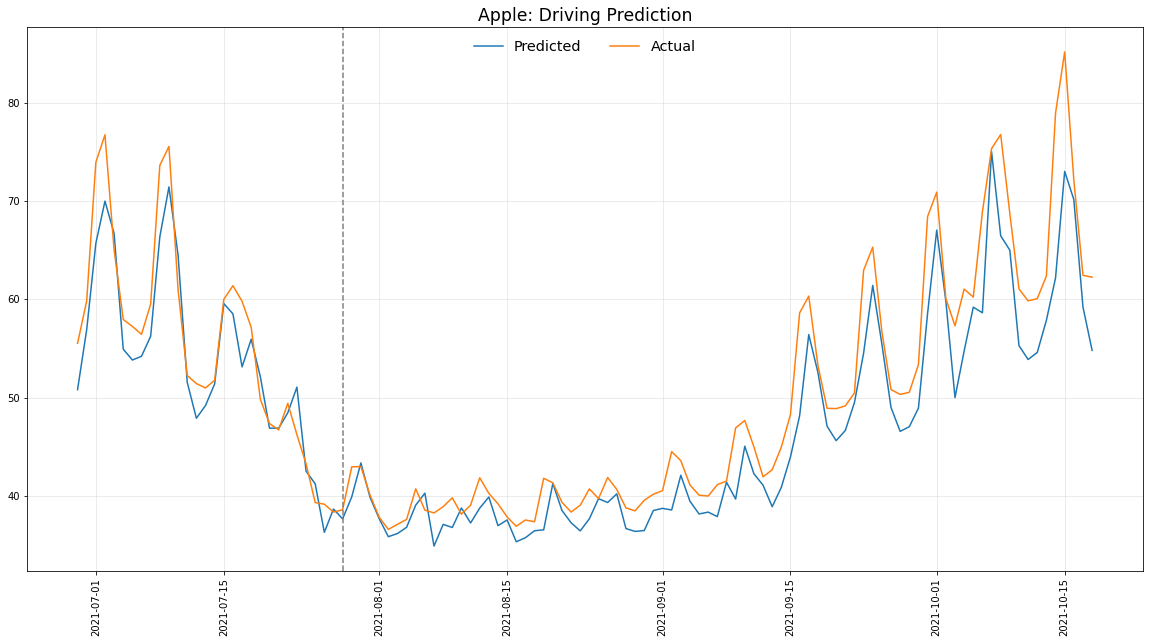

In [93]:

dr = pd.concat([y_apple_total_dr,
                data_apple0.Driving.iloc[lag:].reset_index(drop = True),
                data_apple0.Date.iloc[lag:].reset_index(drop = True)], axis=1)

dr.columns = ['Driving', "Actual", 'Date']

tick_spacing = 5
date_test = data_apple0['Date'][0+index+lag-1]

ax = plt.axes()
plt.plot(dr['Date'],dr['Driving'], label = "Predicted")
plt.plot(dr['Date'],dr['Actual'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Apple: Driving Prediction", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)


# Walking

In [94]:
y_apple_tr = y_apple[0:index+1, :, 1]
y_apple_ts = y_apple[index+1:data_apple.shape[0], :, 1] # walking

## Tuning

In [95]:
seed(1)
tensorflow.random.set_seed(1)

model_apple = Sequential()
model_apple.add(SimpleRNN(1024, activation='relu', input_shape=(X_apple_tr.shape[1], X_apple_tr.shape[2])))
# model_apple.add(Dense(2, activation = "relu"))
model_apple.add(Dense(1, activation = "linear"))
model_apple.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_apple.fit(X_apple_tr, y_apple_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

scores_apple1 = model_apple.evaluate(X_apple_tr, y_apple_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_apple1[1])

scores_apple = model_apple.evaluate(X_apple_ts, y_apple_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_apple[1])


# make a prediction
# training set
y_apple_tr = pd.DataFrame(model_apple.predict(X_apple_tr))

# test set
y_apple_ts = pd.DataFrame(model_apple.predict(X_apple_ts))

# combine training and test predictions
y_apple_total_dr = pd.concat([y_apple_tr, y_apple_ts], ignore_index=True)



MAPE: training =  4.291120529174805
MAPE: test =  5.3058624267578125


In [96]:
# LSTM
def evaluate_lstm(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(LSTM(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


units = [2, 4,8,16,32,64,128,256,512, 1024]

lstm_apple = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_apple_tr, y_apple_tr, i)
  lstm_apple.append(score)

In [97]:
# GRU
def evaluate_gru(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(GRU(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

gru_apple = list()

for i in units:
  score = list()
  score = evaluate_gru(X_apple_tr, y_apple_tr, i)
  gru_apple.append(score)

In [98]:
# RNN
def evaluate_rnn(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(SimpleRNN(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

rnn_apple = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_apple_tr, y_apple_tr, i)
  rnn_apple.append(score)

In [99]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes', '4 Nodes', '8 Nodes', '16 Nodes', '32 Nodes',
                                                   "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes', '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_apple[0],3), 
                                     round(gru_apple[0],3),
                                     round(rnn_apple[0],3), 
                                     round(cnn_apple.iloc[0,0],3),
                                     round(cnn_apple.iloc[0,1],3),
                                     round(cnn_apple.iloc[0,2],3),
                                     round(cnn_apple.iloc[0,3],3),
                                     round(cnn_apple.iloc[0,4],3),
                                     round(cnn_apple.iloc[0,5],3)],
                                     [round(lstm_apple[1],3), 
                                     round(gru_apple[1],3),
                                     round(rnn_apple[1],3), 
                                     round(cnn_apple.iloc[1,0],3),
                                     round(cnn_apple.iloc[1,1],3),
                                     round(cnn_apple.iloc[1,2],3),
                                     round(cnn_apple.iloc[1,3],3),
                                     round(cnn_apple.iloc[1,4],3),
                                     round(cnn_apple.iloc[1,5],3)],
                                     [round(lstm_apple[2],3), 
                                     round(gru_apple[2],3),
                                     round(rnn_apple[2],3), 
                                     round(cnn_apple.iloc[2,0],3),
                                     round(cnn_apple.iloc[2,1],3),
                                     round(cnn_apple.iloc[2,2],3),
                                     round(cnn_apple.iloc[2,3],3),
                                     round(cnn_apple.iloc[2,4],3),
                                     round(cnn_apple.iloc[2,5],3)],
                                     [round(lstm_apple[3],3), 
                                     round(gru_apple[3],3),
                                     round(rnn_apple[3],3), 
                                     round(cnn_apple.iloc[3,0],3),
                                     round(cnn_apple.iloc[3,1],3),
                                     round(cnn_apple.iloc[3,2],3),
                                     round(cnn_apple.iloc[3,3],3),
                                     round(cnn_apple.iloc[3,4],3),
                                     round(cnn_apple.iloc[3,5],3)],
                                     [round(lstm_apple[4],3), 
                                     round(gru_apple[4],3),
                                     round(rnn_apple[4],3), 
                                     round(cnn_apple.iloc[4,0],3),
                                     round(cnn_apple.iloc[4,1],3),
                                     round(cnn_apple.iloc[4,2],3),
                                     round(cnn_apple.iloc[4,3],3),
                                     round(cnn_apple.iloc[4,4],3),
                                     round(cnn_apple.iloc[4,5],3)],
                                     [round(lstm_apple[5],3), 
                                     round(gru_apple[5],3),
                                     round(rnn_apple[5],3), 
                                     round(cnn_apple.iloc[5,0],3),
                                     round(cnn_apple.iloc[5,1],3),
                                     round(cnn_apple.iloc[5,2],3),
                                     round(cnn_apple.iloc[5,3],3),
                                     round(cnn_apple.iloc[5,4],3),
                                     round(cnn_apple.iloc[5,5],3)],
                                     [round(lstm_apple[6],3), 
                                     round(gru_apple[6],3),
                                     round(rnn_apple[6],3), 
                                     round(cnn_apple.iloc[6,0],3),
                                     round(cnn_apple.iloc[6,1],3),
                                     round(cnn_apple.iloc[6,2],3),
                                     round(cnn_apple.iloc[6,3],3),
                                     round(cnn_apple.iloc[6,4],3),
                                     round(cnn_apple.iloc[6,5],3)],
                                     [round(lstm_apple[7],3), 
                                     round(gru_apple[7],3),
                                     round(rnn_apple[7],3), 
                                     round(cnn_apple.iloc[7,0],3),
                                     round(cnn_apple.iloc[7,1],3),
                                     round(cnn_apple.iloc[7,2],3),
                                     round(cnn_apple.iloc[7,3],3),
                                     round(cnn_apple.iloc[7,4],3),
                                     round(cnn_apple.iloc[7,5],3)],
                                     [round(lstm_apple[8],3), 
                                     round(gru_apple[8],3),
                                     round(rnn_apple[8],3), 
                                     round(cnn_apple.iloc[8,0],3),
                                     round(cnn_apple.iloc[8,1],3),
                                     round(cnn_apple.iloc[8,2],3),
                                     round(cnn_apple.iloc[8,3],3),
                                     round(cnn_apple.iloc[8,4],3),
                                     round(cnn_apple.iloc[8,5],3)],
                                     [round(lstm_apple[9],3), 
                                     round(gru_apple[9],3),
                                     round(rnn_apple[9],3), 
                                     round(cnn_apple.iloc[9,0],3),
                                     round(cnn_apple.iloc[9,1],3),
                                     round(cnn_apple.iloc[9,2],3),
                                     round(cnn_apple.iloc[9,3],3),
                                     round(cnn_apple.iloc[9,4],3),
                                     round(cnn_apple.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right', 'right', 'right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Apple Walking",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

## Prediction

In [101]:
seed(1)
tensorflow.random.set_seed(1)

model_apple = Sequential()
model_apple.add(SimpleRNN(256, activation='relu', input_shape=(X_apple_tr.shape[1], X_apple_tr.shape[2])))
# model_apple.add(Dense(2, activation = "relu"))
model_apple.add(Dense(1, activation = "linear"))
model_apple.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_apple.fit(X_apple_tr, y_apple_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

scores_apple1 = model_apple.evaluate(X_apple_tr, y_apple_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_apple1[1])

scores_apple = model_apple.evaluate(X_apple_ts, y_apple_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_apple[1])


# make a prediction
# training set
y_apple_tr = pd.DataFrame(model_apple.predict(X_apple_tr))

# test set
y_apple_ts = pd.DataFrame(model_apple.predict(X_apple_ts))

# combine training and test predictions
y_apple_total_wlk = pd.concat([y_apple_tr, y_apple_ts], ignore_index=True)



MAPE: training =  1.2908819913864136
MAPE: test =  1.335936427116394


## Plot

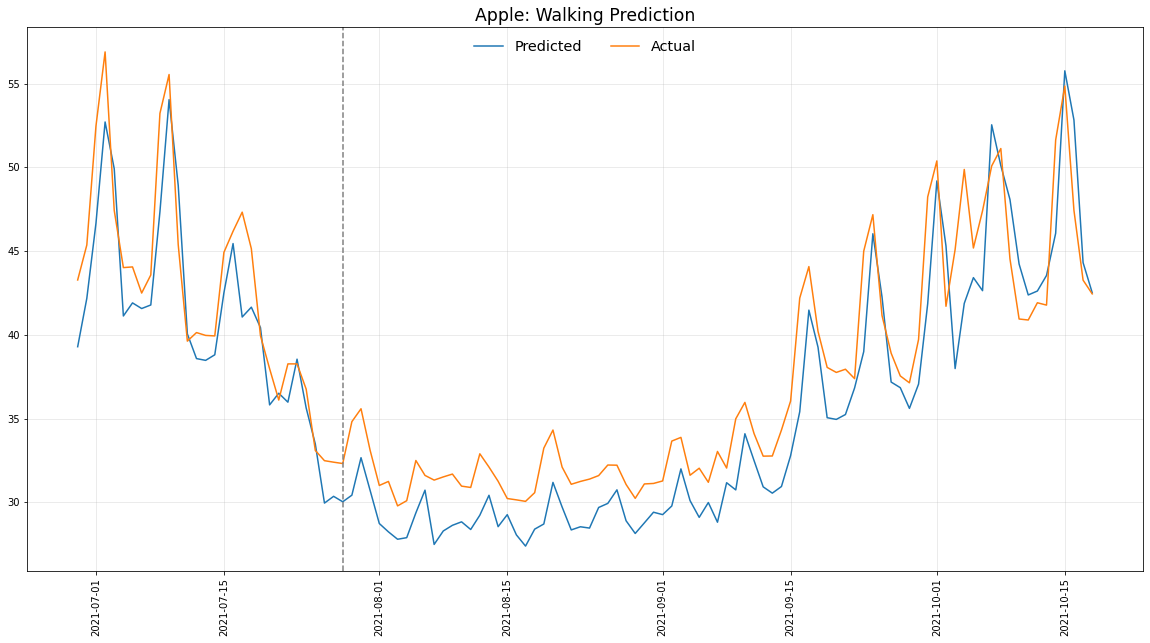

In [102]:

wlk = pd.concat([y_apple_total_wlk,
                data_apple0.Walking.iloc[lag:].reset_index(drop = True),
                data_apple0.Date.iloc[lag:].reset_index(drop = True)], axis=1)

wlk.columns = ['Walking', "Actual", 'Date']

plt.plot(wlk['Date'],wlk['Walking'], label = "Predicted")
plt.plot(wlk['Date'],wlk['Actual'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Apple: Walking Prediction", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)
